
## Time Series data 

* traditional


In [1]:

## !pip install seaborn
## !pip install matplotlib
## !pip install hvplot
## !pip install PyViz
## !pip install statsmodels
## !pip install scikit-learn



In [2]:

import pandas as pd
import numpy as np

import hvplot.pandas
import hvplot

import matplotlib.pyplot as plt

from statsmodels.datasets import co2, get_rdataset
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.filters.hp_filter import hpfilter


In [3]:

import sklearn
import statsmodels
import statsmodels as sm

import warnings

from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error as mape

from itertools import product

from pandas.plotting import autocorrelation_plot

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [12, 5]  



## CIVS time series data


In [ ]:

df_data = pd.read_csv('data/RealSeqData.CIVS.Nov.2023.csv')


In [ ]:

df_data.head()


In [ ]:

ts_data = pd.read_csv(
            'data/RealSeqData.CIVS.Nov.2023.csv',
            header=0,
            parse_dates = ['time'],
            index_col=0,
            infer_datetime_format=True
)


In [ ]:

ts_data.head(5)


In [ ]:

ts_data.info()


In [ ]:

ts_data.plot()


In [ ]:

## ts_data.hvplot()


In [ ]:

ts_data.plot( figsize=(20,80),  subplots=True   )


In [ ]:

## ts_data.hvplot( width=300,  subplots=True   ).cols(3)


In [ ]:

## (ts_data['o_SILICON_14'].hvplot(width=400) + ts_data['NAT_GAS_INJECTION'].hvplot(width=400))



## Split Time Series Data


In [4]:

def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test


In [5]:

test_split = 0.20

ts_data_train, ts_data_test = split_data(ts_data, test_split)



NameError: name 'ts_data' is not defined

In [ ]:

ts_data_train.info()


In [ ]:

ts_data_test.info()



## Utility Functions


In [6]:

def check_stationarity(df):
    
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    
    return (s, results[0])


In [7]:

def get_best_model(score, c='AIC'):
    
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
            
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    
    return score[best_model]['model']


In [8]:

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax


In [9]:

def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo



## Blast 14 all data



## Silicon data only


In [10]:

plt.rcParams["figure.figsize"] = (10, 3)


In [11]:


ts_silicon_data = pd.read_csv(
            'data/RealSeqData.CIVS.Nov.2023.csv',
            header=0,
            parse_dates = ['time'],
            index_col=0,
            infer_datetime_format=True,
            usecols=['time', 'o_SILICON_14']
)


In [12]:

ts_silicon_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265020 entries, 2021-08-01 00:00:00 to 2022-01-31 23:59:00
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   o_SILICON_14  265020 non-null  float64
dtypes: float64(1)
memory usage: 4.0 MB


<AxesSubplot:xlabel='time'>

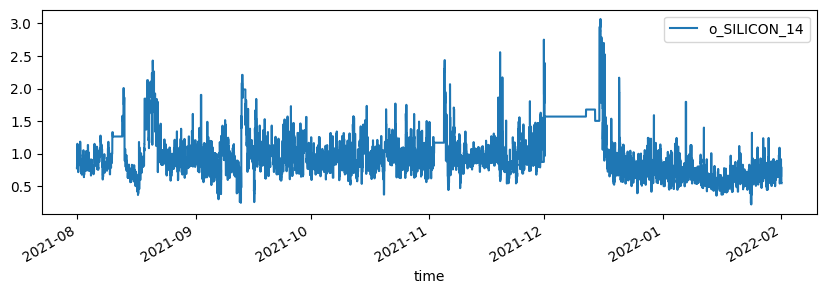

In [13]:

ts_silicon_data.plot()



## Silicon Trend, Seasonality, and residual


In [ ]:

## ts_silicon_data_decomposed = seasonal_decompose(ts_silicon_data, model='multiplicative')

silicon_cyclic, silicon_trend = hpfilter(ts_silicon_data)


In [ ]:



fig, ax = plt.subplots(1,2, figsize=(16, 4))

silicon_cyclic.plot(ax=ax[0], title='Silicon Cyclic Component')
silicon_trend.plot(ax=ax[1], title='Silicon Trend Component')

#fig.savefig('images/fig_9.18.png', bbox_inches='tight')



In [ ]:

ts_silicon_data_diff = ts_silicon_data.diff().dropna()
ts_silicon_data_diff.plot()




## Silicon Plotting ACF and PACF


In [ ]:

# plt.rcParams["figure.figsize"] = [16, 4]

## ts_data_train.plot()



In [ ]:

check_stationarity( ts_silicon_data_diff )


In [ ]:

fig, ax = plt.subplots(2,1, figsize=(12,8))

plot_acf( ts_silicon_data_diff, zero=False, ax=ax[0])
plot_pacf(ts_silicon_data_diff, zero=False, ax=ax[1])

#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)

plt.show()


In [ ]:


ts_silicon_data_diff_12 = ts_silicon_data.diff(12).dropna()


In [ ]:

check_stationarity(ts_silicon_data_diff_12)


In [ ]:

ts_silicon_data_diff_12_1 = ts_silicon_data.diff(12).diff(1).dropna()
check_stationarity(ts_silicon_data_diff_12_1)


In [ ]:

fig, ax = plt.subplots(2,1, figsize=(12,8))

plot_acf( ts_silicon_data_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(ts_silicon_data_diff_12_1, zero=False, ax=ax[1], lags=36)

# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()



## Silicon SARIMAX


In [ ]:



model = SARIMAX(
                 ts_silicon_data, 
                 order=(0,1,1),
                 seasonal_order=(0,1,1, 12) 
).fit(disp=False)

plot_acf(model.resid[1:], zero=False)

#plt.savefig('images/fig_10.4.png', bbox_inches='tight', dpi=300)

plt.show()


In [ ]:

model.resid[1:].plot()


In [ ]:

model.plot_diagnostics();


In [ ]:

model.resid[1:]



## Silicon Forecasting Univariate Time Series Data with Exponential Smoothing


In [ ]:

trend = ['add', 'mul']
damped = [True, False]

silicon_ex_comb = combinator([trend, damped])

silicon_ex_comb



## Split silicon data train test 


In [14]:

test_split = 0.20

ts_silicon_data_train, ts_silicon_data_test = split_data(ts_silicon_data, test_split)



train: 212016 , test: 53004


In [ ]:



train_silicon = ts_silicon_data_train.values.ravel()
y_silicon     = ts_silicon_data_test.values.ravel()

score = {}
for i, (t, dp) in enumerate(silicon_ex_comb):
    
    exp = ExponentialSmoothing(train_silicon, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast( len(y_silicon) )
    
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y_silicon, y_hat),
                'RMSE' : rmse( y_silicon, y_hat),
                'MAPE' : mape( y_silicon, y_hat),
                'model': model}


In [ ]:

silicon_best_model = get_best_model(score, 'AIC')


In [ ]:

silicon_best_model.summary()


In [ ]:

silicon_best_model.params_formatted


In [ ]:

plot_forecast(silicon_best_model, '2017', ts_silicon_data_train, ts_silicon_data_test)

#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)


In [ ]:

trend , damped    = ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]

silicon_exp_comb = combinator([trend, damped, seasonal, periods])


In [ ]:

len(silicon_exp_comb)


In [ ]:

train_silicon = ts_silicon_data_train.values.ravel()
y_silicon     = ts_silicon_data_test.values.ravel()

silicon_model_scores = {}

for i, (t, dp, s, sp) in enumerate(silicon_exp_comb):
    exp = ExponentialSmoothing(train_silicon, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    
    model = exp.fit(use_brute=True, optimized=True)   
    
    y_hat = model.forecast(len(y_silicon))
    silicon_model_scores[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc': model.aicc,
                'RMSPE': rmspe(y_silicon, y_hat),
                'RMSE' : rmse( y_silicon, y_hat),
                'MAPE' : mape( y_silicon, y_hat),
                'model': model}


In [ ]:

silicon_model = get_best_model(silicon_model_scores)


In [ ]:

silicon_model.summary()


In [ ]:

plot_forecast(silicon_model, '1969', ts_silicon_data_train, ts_silicon_data_test)
# plt.savefig('images/fig_10.8.png', bbox_inches='tight', dpi=300)



## Silicon  Time Series Data with Non-Seasonal ARIMA


In [ ]:

plt.rcParams["figure.figsize"] = [14, 4] 


In [ ]:

'''
decomposed = seasonal_decompose(ts_silicon_data)
decomposed.plot()
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)
plt.show()

'''



In [ ]:

plt.rcParams["figure.figsize"] = [14, 6]  

decomposed = seasonal_decompose(ts_silicon_data, period=12)
decomposed.plot(); plt.show()


In [ ]:

autocorrelation_plot(ts_silicon_data)


In [ ]:

check_stationarity(ts_silicon_data)


In [ ]:

ts_silicon_data_df1 = ts_silicon_data.diff().dropna()
check_stationarity(ts_silicon_data_df1)


In [ ]:

ts_silicon_data_df1.plot()
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)


In [ ]:

fig, ax = plt.subplots(1,2)

plot_acf( ts_silicon_data_df1, ax=ax[0])
plot_pacf(ts_silicon_data_df1, ax=ax[1])
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:

(acorr_ljungbox(ts_silicon_data_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()



In [ ]:

## ts_silicon_data_train, ts_silicon_data_test

model = ARIMA(ts_silicon_data_train, order=(0,1,1))
results = model.fit()
results.summary()


In [ ]:

(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()


In [ ]:

plot_acf(results.resid, zero=False);plt.show()


In [ ]:

results.plot_diagnostics()
#plt.savefig('images/fig_10.15.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:

(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()


In [ ]:

from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05


In [ ]:



plot_forecast(results, '1998', ts_silicon_data_train, ts_silicon_data_test)



## Another try


In [ ]:

## ts_silicon_data_train, ts_silicon_data_test

pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}

for i, (p, d, q) in enumerate(vals):
    m = ARIMA(ts_silicon_data_train, order=(p,d,q))
    res = m.fit()
    
    y = ts_silicon_data_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse( y, y_hat),
                'MAPE' : mape( y, y_hat),
                'model': res}


In [ ]:

get_best_model(score, 'AIC')


In [ ]:

best_m = get_best_model(score, 'AIC')


In [ ]:

score[8]


In [ ]:

score[4]['model'].model_orders


In [ ]:

pd.DataFrame(score).T.sort_values(by='AIC').reset_index()


In [ ]:

pd.DataFrame(score).T.sort_values(by='BIC').reset_index()


In [ ]:

best_m.summary()


In [ ]:

## ts_silicon_data_train, ts_silicon_data_test

plot_forecast(best_m, '1998', ts_silicon_data_train,  ts_silicon_data_test)



## Silicon  Seasonal ARIMA (SARIMAX)


In [ ]:


plt.rcParams["figure.figsize"] = [14, 4]  


In [ ]:

ts_silicon_data.plot()


In [ ]:

plot_acf( ts_silicon_data, lags=40, zero=False)
plot_pacf(ts_silicon_data, lags=40, zero=False);plt.show()


In [ ]:

plot_acf(ts_silicon_data.diff(1).dropna(), lags=40, zero=False); plt.show()


In [ ]:

decomposed = seasonal_decompose(ts_silicon_data, period=12, model='multiplicative')
decomposed.plot(); plt.show()


In [ ]:

silicon_s = decomposed.seasonal


In [ ]:

plot_acf(silicon_s, zero=False, lags=40);plt.show()


In [ ]:

ts_silicon_data_dif_12   = ts_silicon_data.diff(12).dropna()
ts_silicon_data_dif_12_1 = ts_silicon_data.diff(12).diff(1).dropna()


In [ ]:

sets = [ts_silicon_data, ts_silicon_data_dif_12, ts_silicon_data_dif_12_1]

desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))

index, l = ts_silicon_data.index, ts_silicon_data.shape[0]

for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()



## How to Determine AR and MA terms


In [ ]:

fig, ax = plt.subplots(1,2)

plot_acf( ts_silicon_data_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(ts_silicon_data_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()


In [ ]:

#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)

plot_acf( ts_silicon_data.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(ts_silicon_data.diff(12).diff(1).dropna(),zero=False, lags=lags);


In [ ]:

## ts_silicon_data_train

sarima_model = SARIMAX(ts_silicon_data_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))

model = sarima_model.fit(disp=0)


In [ ]:

model.plot_diagnostics(figsize=(15,10))
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:

model.summary()


In [ ]:

model.resid[1:].plot()


In [ ]:

plot_acf( model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()


In [ ]:

plot_forecast(model, '1971', ts_silicon_data_train, ts_silicon_data_test)
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)


In [ ]:

n = ts_silicon_data.shape[0]
ts_silicon_data_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])



## SARIMAX silicon With grid search


In [ ]:


P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s,  D_s,  Q_s  = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}

for i, (p, d, q, P, D, Q) in enumerate(vals):
 
    m = SARIMAX(ts_silicon_data_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    
    res = m.fit()
    
    y = ts_silicon_data_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}
    
    



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51765D+00    |proj g|=  6.04725D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.047D-06   1.518D+00
  F =   1.5176450108395350     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.



At iterate    5    f=  8.86900D-01    |proj g|=  2.37127D-02

At iterate   10    f=  8.79721D-01    |proj g|=  6.93971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     17      1     0     0   1.781D-05   8.797D-01
  F =  0.87972083544329360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09496D+00    |proj g|=  7.68483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     13      1     0     0   7.685D-04  -1.095D+00
  F =  -1.0949596480862018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09963D+00    |proj g|=  1.09697D-01


 This problem is unconstrained.



At iterate    5    f= -1.09971D+00    |proj g|=  1.41284D-01

At iterate   10    f= -1.09984D+00    |proj g|=  1.25905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     15      1     0     0   1.056D-04  -1.100D+00
  F =  -1.0998416612373250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09564D+00    |proj g|=  1.52782D-03


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   1.528D-03  -1.096D+00
  F =  -1.0956355164948268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10034D+00    |proj g|=  1.10662D-01


 This problem is unconstrained.



At iterate    5    f= -1.10040D+00    |proj g|=  5.47837D-02

At iterate   10    f= -1.10046D+00    |proj g|=  1.24842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.318D-05  -1.100D+00
  F =  -1.1004593462038494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09949D+00    |proj g|=  1.53975D-03


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   1.540D-03  -1.099D+00
  F =  -1.0994930146882937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09935D+00    |proj g|=  1.56539D-02

At iterate    5    f= -1.09953D+00    |proj g|=  8.08476D-03

At iterate   10    f= -1.10054D+00    |proj g|=  1.32519D-02

At iterate   15    f= -1.10113D+00    |proj g|=  2.10556D-02

At iterate   20    f= -1.10385D+00    |proj g|=  1.02585D-01

At iterate   25    f= -1.10627D+00    |proj g|=  6.20527D-02

At iterate   30    f= -1.10698D+00    |proj g|=  5.40900D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.70997D-01    |proj g|=  5.98675D-02

At iterate   10    f=  8.36919D-01    |proj g|=  6.13281D-03

At iterate   15    f=  8.36448D-01    |proj g|=  4.89753D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     18      1     0     0   4.898D-07   8.364D-01
  F =  0.83644819360368139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15927D+00    |proj g|=  6.48910D-01

At iterate    5    f=  2.85416D-01    |proj g|=  8.39199D-02

At iterate   10    f=  2.16215D-01    |proj g|=  2.73087D-02

At iterate   15    f=  2.12782D-01    |proj g|=  1.74334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     26      1     0     0   9.029D-07   2.126D-01
  F =  0.21263817230750268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f= -1.54862D+00    |proj g|=  2.24473D+00

At iterate   10    f= -1.57118D+00    |proj g|=  2.04752D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     27      1     0     0   2.456D-03  -1.571D+00
  F =  -1.5711845493294725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08563D+00    |proj g|=  3.55437D+00


 This problem is unconstrained.



At iterate    5    f= -1.56308D+00    |proj g|=  1.05499D+00

At iterate   10    f= -1.58648D+00    |proj g|=  7.17127D-02

At iterate   15    f= -1.58947D+00    |proj g|=  3.23541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   1.977D-06  -1.589D+00
  F =  -1.5894710453226026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01995D+00    |proj g|=  9.01376D-01
  ys=-3.098E+00  -gs= 1.059E+00 BFGS update SKIPPED

At iterate    5    f= -1.20527D+00    |proj g|=  6.70976D+00

At iterate   10    f= -1.56799D+00    |proj g|=  1.10052D+00

At iterate   15    f= -1.57208D+00    |proj g|=  2.19763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     30      2     1     0   5.920D-05  -1.572D+00
  F =  -1.5720827321143664     

CONVERGENCE: REL_

 This problem is unconstrained.


  ys=-1.897E+00  -gs= 1.061E+00 BFGS update SKIPPED

At iterate    5    f= -1.13746D+00    |proj g|=  2.63366D+00

At iterate   10    f= -1.57357D+00    |proj g|=  2.97726D-01

At iterate   15    f= -1.58741D+00    |proj g|=  6.79344D-02

At iterate   20    f= -1.59006D+00    |proj g|=  1.06976D-02


In [ ]:

best_model = get_best_model(score, 'AIC')


In [ ]:

results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)


In [ ]:

results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(20)


In [ ]:

score[211]


In [ ]:

plot_forecast(best_model, '1971', ts_silicon_data_train, ts_silicon_data_test)
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)



## CO2 book example


In [ ]:

co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()


In [ ]:

co2_df.plot()


In [ ]:

## co2_df.hvplot()


In [ ]:

co2_decomposed = seasonal_decompose(co2_df, model='additive')


In [ ]:

co2_decomposed.plot(); plt.show()


In [ ]:

co2_cyclic, co2_trend = hpfilter(co2_df)


In [ ]:

fig, ax = plt.subplots(1,2, figsize=(16, 4))

co2_cyclic.plot(ax=ax[0], title='CO2 Cyclic Component')
co2_trend.plot(ax=ax[1],  title='CO2 Trend Component')

#fig.savefig('images/fig_9.18.png', bbox_inches='tight')



## Air passengers example


In [ ]:

air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)


In [ ]:

airp_df.plot()


In [ ]:

## airp_df.hvplot()


In [ ]:

airp_df['value'].plot()


In [ ]:

airp_df_decomposed = seasonal_decompose(airp_df, model='multiplicative')


In [ ]:

airp_df_decomposed.plot(); plt.show()
